<a href="https://colab.research.google.com/github/jntanner83/Farmbot/blob/main/Vgg16Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=855a107eebb7bf74e56cee6cbb6fa4e9953f7ccbe6e117c1ce55d2aeb97965ee
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR  # Optional, if you decide to use a learning rate scheduler
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import numpy as np
import matplotlib.pyplot as plt
import time
import copy  # Useful for deep copying the models; for example, to keep a copy of the best model
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet50
from collections import Counter
import random
from PIL import Image
import seaborn as sns
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


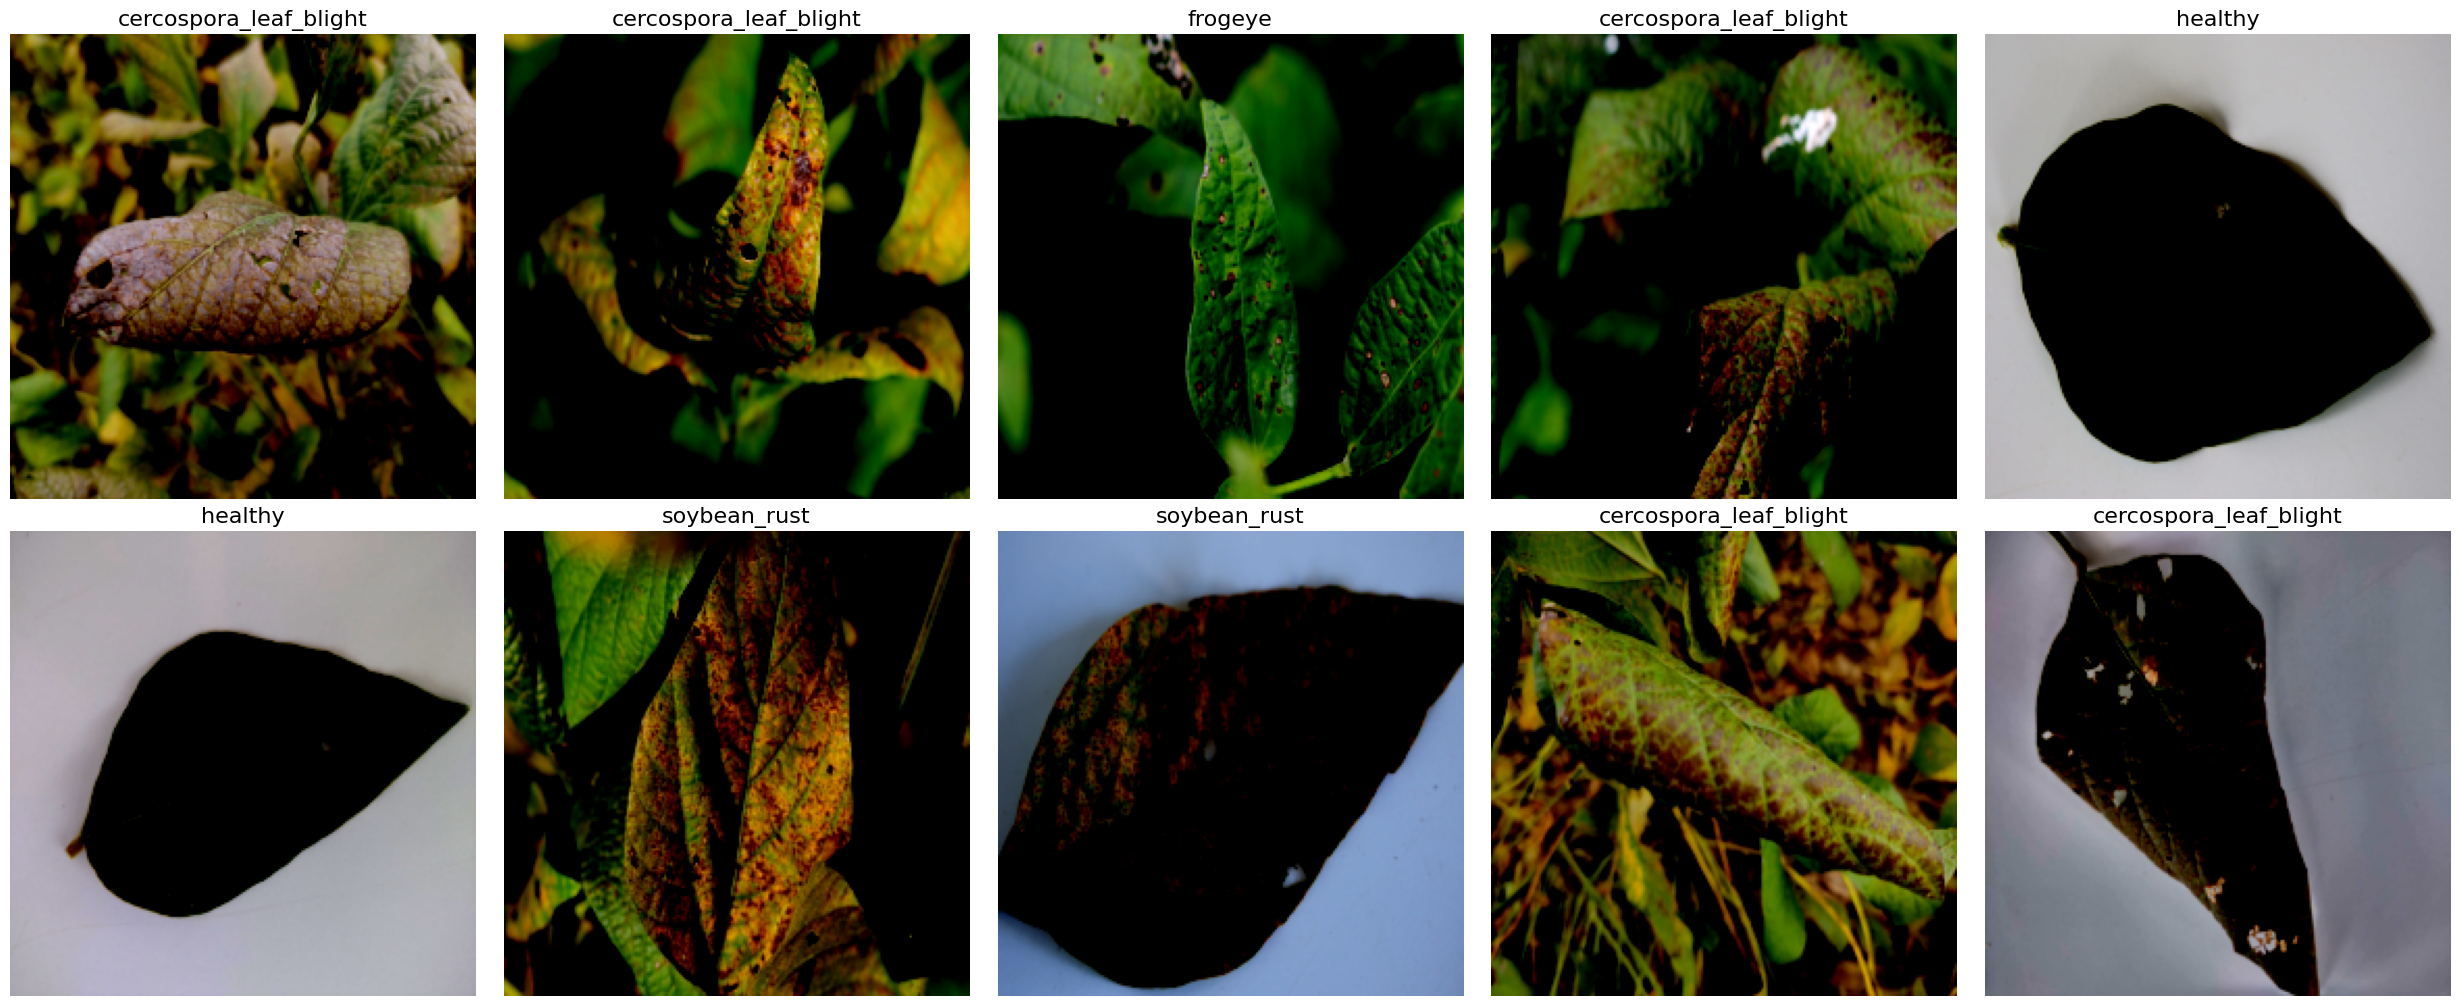

In [ ]:
# Set the path to your image directory
image_dir = '/content/drive/My Drive/Capstone/images'

#Transforms
transformer=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

# Load the dataset
dataset = datasets.ImageFolder(image_dir, transform=transformer)
class_names = dataset.classes

# Randomly select 10 images
indices = np.random.choice(range(len(dataset)), 10, replace=False)
selected_images_and_labels = [(dataset[idx][0], dataset.classes[dataset[idx][1]]) for idx in indices]
# Function to convert a tensor to a numpy array suitable for plotting
def tensor_to_numpy(tensor):
    return tensor.numpy().transpose((1, 2, 0))

# Plotting selected images with labels
fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # Adjust the figure size as needed
fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust space as needed
axs = axs.ravel()

for i, (img_tensor, label) in enumerate(selected_images_and_labels):
    img = tensor_to_numpy(img_tensor)
    axs[i].imshow(img)
    axs[i].set_title(label, fontsize=16)
    axs[i].set_axis_off()

plt.tight_layout(pad=0.5)
plt.show()


# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
# Get the class names
root = pathlib.Path(image_dir)
class_counts = {}
for class_dir in root.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name.split('/')[-1]
        class_counts[class_name] = len(list(class_dir.glob('*')))

classes = sorted(list(class_counts.keys()))

print("Classes:", classes)
print("Class Counts:", class_counts)

Classes: ['bacterial_blight', 'cercospora_leaf_blight', 'frogeye', 'healthy', 'soybean_rust']
Class Counts: {'soybean_rust': 1627, 'healthy': 1632, 'bacterial_blight': 484, 'cercospora_leaf_blight': 1598, 'frogeye': 606}


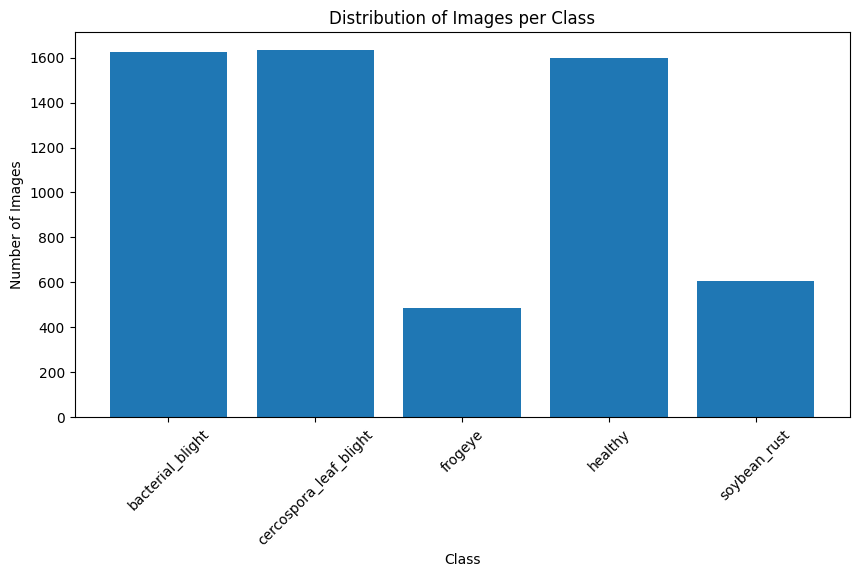

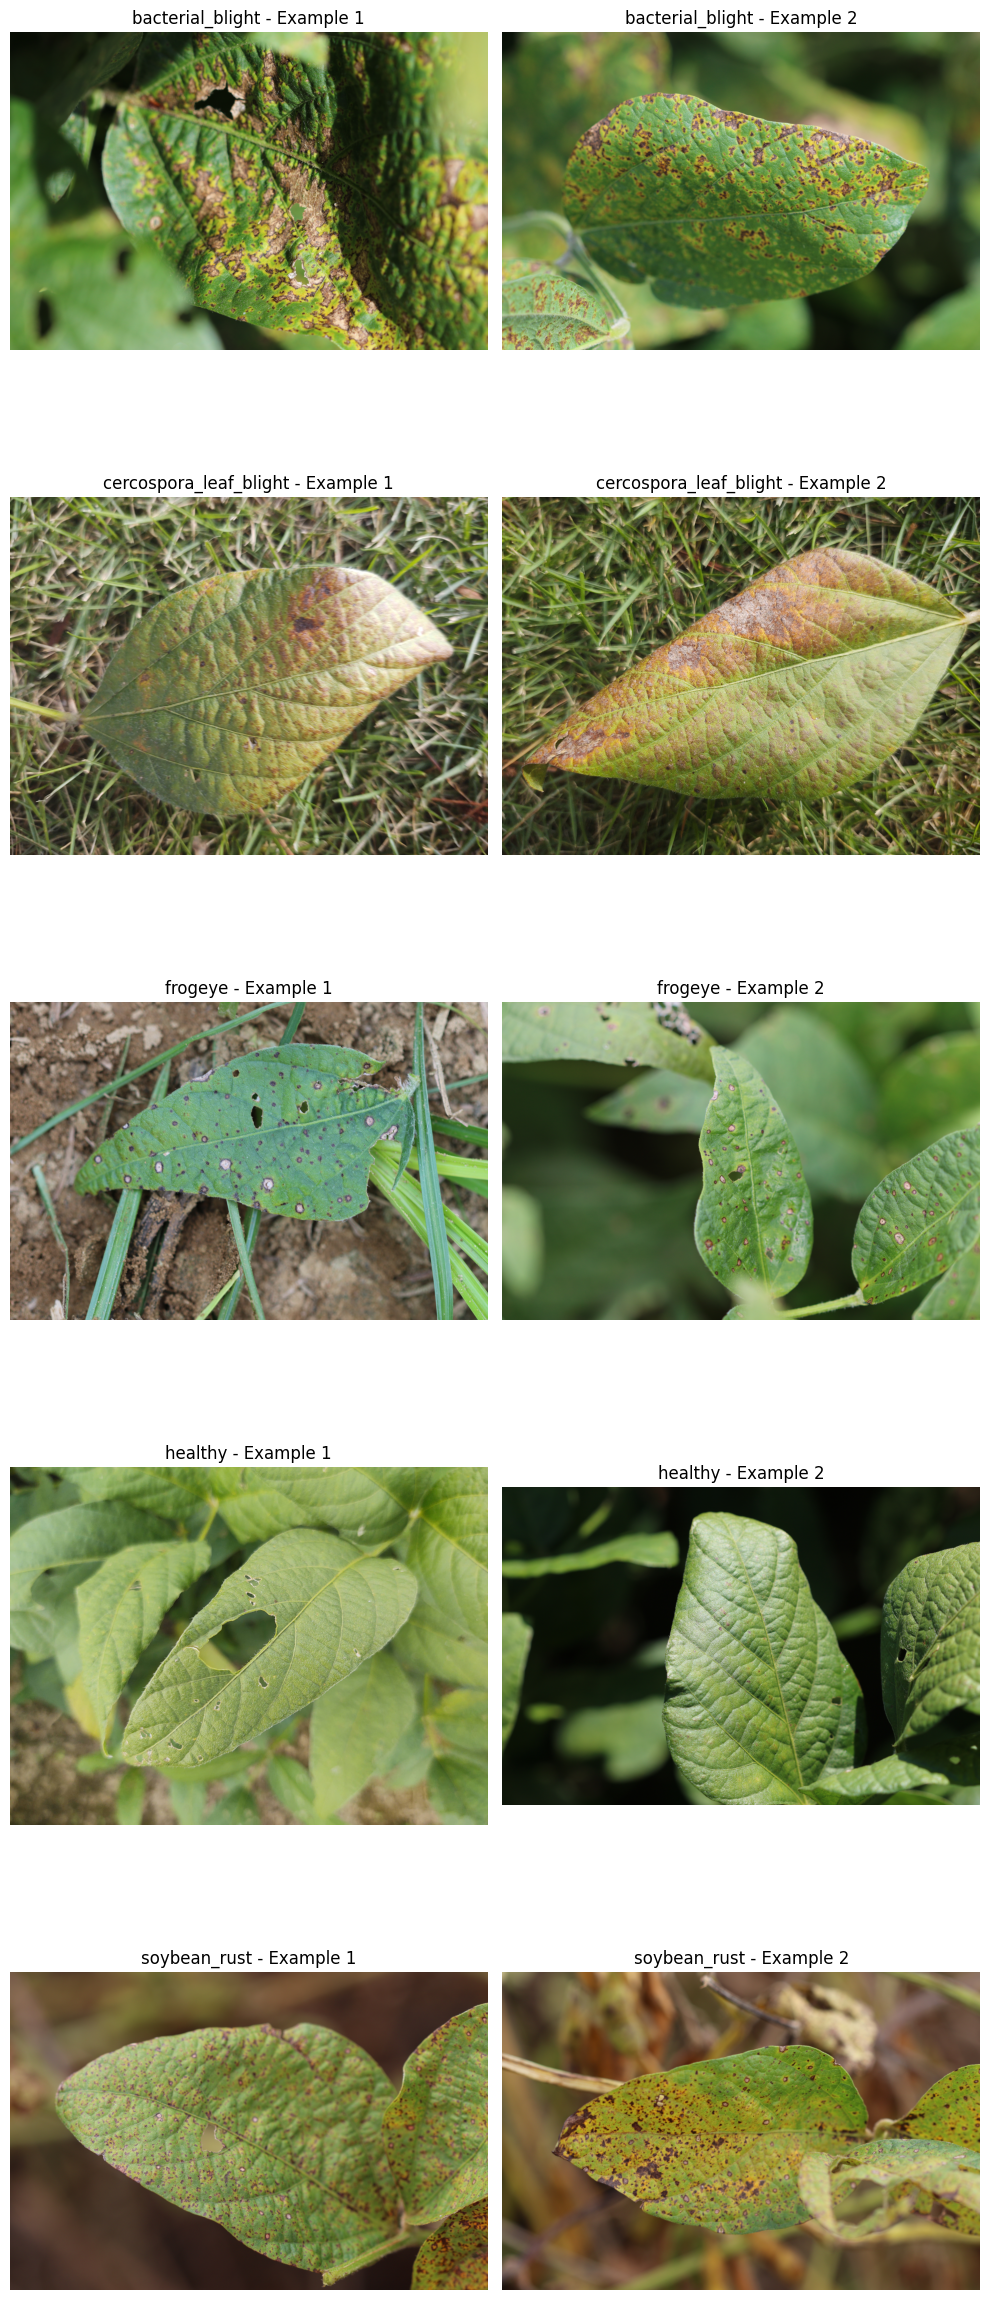

In [ ]:
# Plot the distribution of images in each class
plt.figure(figsize=(10, 5))
plt.bar(classes, class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class')
plt.xticks(rotation=45)
plt.show()

# Display two example images from each class
fig, axes = plt.subplots(len(classes), 2, figsize=(10, 5*len(classes)))
for i, class_name in enumerate(classes):
    class_dir = root / class_name
    image_files = list(class_dir.glob('*'))[:2]  # Get the first two image files
    for j, image_file in enumerate(image_files):
        image = plt.imread(str(image_file))
        axes[i, j].imshow(image)
        axes[i, j].set_title(f'{class_name} - Example {j+1}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=5):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)



        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)


        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)


            #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)

        return output


In [ ]:
model=ConvNet(num_classes=5).to(device)

In [ ]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [ ]:
num_epochs=10

In [ ]:
train_count = len(train_dataset)
test_count = len(test_dataset)
print("Number of training images:", train_count)
print("Number of testing images:", test_count)

Number of training images: 4757
Number of testing images: 1190


In [ ]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count


    # Evaluation on testing dataset
    model.eval()

    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))

    test_accuracy=test_accuracy/test_count


    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy


KeyboardInterrupt: 